<a href="https://colab.research.google.com/github/koyomin9zx/GunDetector/blob/master/GunDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
## slim là package đi kèm với tensorflow, giúp định nghĩa nhanh các loại mô hình deep learning
import tensorflow.contrib.slim as slim
import tensorflow.contrib.slim.nets
from tensorflow.contrib.slim.nets import vgg 
## sklearn là một thư viện rất phổ biến trong ML, chúng ta chỉ sử dụng tran_test_split để chia data thành 2 tập
from sklearn.model_selection import train_test_split
import json
## thư viện tính toán trên matrix
import numpy as np
import cv2
# thư viện hiển thị biểu đồ
import matplotlib.pyplot as plt
import time
import glob
import re
import os
import random
from keras.preprocessing.image import load_img
from imutils import paths

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip /content/drive/'My Drive'/ML/data.zip

In [0]:
!ln -s /content/drive/'My Drive'/ML/backup /content

In [0]:
# kích thước grid system 
cell_size = 7 
# số boundary box cần dự đoán mỗi ô vuông
box_per_cell = 2
# kích thước ảnh đầu vào
img_size = 224
# số loại nhãn
classes = {'gun':0}
nclass = len(classes)

box_scale = 10.0
noobject_scale = 0.1
batch_size = 128

# learning rate
lr = 1e-5

In [0]:
def load():
    path = 'images/*.*'
    files = glob.glob(path)
    # số lương ảnh
    N = len(files)

    # matrix chứa ảnh
    X = np.zeros((N, img_size, img_size, 3), dtype='uint8')

    # matrix chứa nhãn của ảnh tương ứng
    y = np.zeros((N,cell_size, cell_size, 5+nclass),dtype='uint8')

    # Lấy các đường dẫn đến ảnh.
    image_path = list(paths.list_images('images/'))
    
    # Đổi vị trí ngẫu nhiên các đường dẫn ảnh
    random.shuffle(image_path)

    for (idx, imagePath) in enumerate(image_path):
      img = load_img(imagePath, target_size=(224, 224))
      X[idx] = img
      name=os.path.basename(imagePath)
      with open('labels/'+os.path.splitext(name)[0]+'.txt') as f:
          for line in f:
              # tâm của boundary box
              x_center, y_center, w, h = float(line.split()[1])*img_size, float(line.split()[2])*img_size, float(line.split()[3])*img_size, float(line.split()[4])*img_size
              # index của object trên ma trận ô vuông 7x7
              x_idx, y_idx = int(x_center/img_size*cell_size), int(y_center/img_size*cell_size)
              # gán nhãn vào matrix 
              y[idx, y_idx, x_idx] = 1, x_center, y_center, w, h, 1
    return X, y

In [0]:
X, y = load()
#chia train set, test set theo tỉ lệ 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2018)

#từ train set chia thành 2 tập train:validate theo tỉ lệ 5:1
X_val, y_val = X_train[2000:2400], y_train[2000:2400]
X_train,y_train=X_train[:2000], y_train[:2000]

In [0]:
def vgg16(inputs, is_training,keep_prob):
    """định nghĩa CNN
    Args:
      inputs: 5-D tensor [batch_size, width, height, 3]
    Return:
      4-D tensor [batch_size, 7, 7, 5*nbox + nclass]
    """
    # khái báo scope để có thê group những biến liên quan cho việc visualize trên tensorboard.
    with tf.variable_scope("vgg_16"):
        with slim.arg_scope(vgg.vgg_arg_scope()):
            # hàm repeat có tác dụng lặp lại tầng conv2d n lần mà không phải định nghĩa phức tạp.
            net = slim.repeat(inputs, 2, slim.conv2d, 16, [3, 3], scope='conv1')
            net = slim.max_pool2d(net, [2, 2], scope='pool1')
            net = slim.repeat(net, 2, slim.conv2d, 32, [3, 3], scope='conv2')
            net = slim.max_pool2d(net, [2, 2], scope='pool2')
            net = slim.repeat(net, 2, slim.conv2d, 64, [3, 3], scope='conv3')
            net = slim.max_pool2d(net, [2, 2], scope='pool3')
            net = slim.repeat(net, 2, slim.conv2d, 128, [3, 3], scope='conv4')
            net = slim.max_pool2d(net, [2, 2], scope='pool4')
            net = slim.repeat(net, 2, slim.conv2d, 256, [3, 3], scope='conv5')
            net = slim.max_pool2d(net, [2, 2], scope='pool5')

            # thay vì sử dụng 2 tầng fully connected tại đây, 
            # chúng ta sử dụng conv với kernel_size = (1,1) có tác dụng giống hệt tầng fully conntected
            
            net = slim.conv2d(net, 512, [1, 1], scope='fc6') 
            #net = tf.nn.dropout(net, keep_prob)  
            net = slim.conv2d(net, 11, [1, 1], activation_fn=None, scope='fc7')

    return net

In [0]:
def model_summary():
    model_vars = tf.trainable_variables()
    slim.model_analyzer.analyze_vars(model_vars, print_info=True)


In [0]:
def compute_iou(boxes1, boxes2, scope='iou'):
    """calculate ious
    Args:
      boxes1: (x_center, y_center, w, h)
      boxes2: (x_center, y_center, w, h)
    Return:
      iou
    """
    with tf.variable_scope(scope):
        # transform (x_center, y_center, w, h) to (x1, y1, x2, y2)
        boxes1_t = tf.stack([boxes1[..., 0] - boxes1[..., 2] / 2.0,
                             boxes1[..., 1] - boxes1[..., 3] / 2.0,
                             boxes1[..., 0] + boxes1[..., 2] / 2.0,
                             boxes1[..., 1] + boxes1[..., 3] / 2.0],
                            axis=-1)

        boxes2_t = tf.stack([boxes2[..., 0] - boxes2[..., 2] / 2.0,
                             boxes2[..., 1] - boxes2[..., 3] / 2.0,
                             boxes2[..., 0] + boxes2[..., 2] / 2.0,
                             boxes2[..., 1] + boxes2[..., 3] / 2.0],
                            axis=-1)

        # calculate the left up point & right down point
        lu = tf.maximum(boxes1_t[..., :2], boxes2_t[..., :2])
        rd = tf.minimum(boxes1_t[..., 2:], boxes2_t[..., 2:])

        # intersection
        intersection = tf.maximum(0.0, rd - lu)
        inter_square = intersection[..., 0] * intersection[..., 1]

        # calculate the boxs1 square and boxs2 square
        square1 = boxes1[..., 2] * boxes1[..., 3]
        square2 = boxes2[..., 2] * boxes2[..., 3]

        union_square = tf.maximum(square1 + square2 - inter_square, 1e-10)

    return tf.clip_by_value(inter_square / union_square, 0.0, 1.0)

In [0]:
def loss_layer(predicts, labels, scope='loss_layer'):
    """calculate loss function
    Args:
      predicts: 4-D tensor [batch_size, 7, 7, 5*nbox+n_class] 
      labels: 4-D tensor [batch_size, 7, 7, 5*nbox+n_class]
    Return:
      loss: scalar
    """
    with tf.variable_scope(scope):
        offset = np.transpose(np.reshape(np.array(
            [np.arange(cell_size)] * cell_size * box_per_cell),
            (box_per_cell, cell_size, cell_size)), (1, 2, 0))
        offset = offset[None, :]
        offset = tf.constant(offset, dtype=tf.float32)
        offset_tran = tf.transpose(offset, (0, 2, 1, 3))
        
        # 2 phần tử đầu của vector dự đoán tại một ô vuông là confidence score
        predict_object = predicts[..., :box_per_cell]
        
        # 8 phần tử tiếp theo là dự đoán offset của boundary box và width height
        predict_box_offset = tf.reshape(predicts[...,box_per_cell:5*box_per_cell], (-1, cell_size, cell_size, box_per_cell, 4))
        
        # các phần tử cuối là dự đoán lớp của object
        predict_class = predicts[...,5*box_per_cell:]
        
        # chuyển vị trí offset về toạ độ normalize trên khoảng [0-1]
        predict_normalized_box = tf.stack(
                                    [(predict_box_offset[..., 0] + offset) / cell_size,
                                     (predict_box_offset[..., 1] + offset_tran) / cell_size,
                                     tf.square(predict_box_offset[..., 2]),
                                    tf.square(predict_box_offset[..., 3])], axis=-1)

        # lấy các nhãn tương ứng 
        true_object = labels[..., :1]
        true_box = tf.reshape(labels[..., 1:5], (-1, cell_size, cell_size, 1, 4))
        
        # để normalize tọa độ pixel về đoạn [0-1] chúng ta chia cho img_size (224)
        true_normalized_box = tf.tile(true_box, (1, 1, 1, box_per_cell, 1))/img_size
        true_class = labels[..., 5:]
        
        # tính vị trí offset từ nhãn 
        true_box_offset =  tf.stack(
                                    [true_normalized_box[..., 0] * cell_size - offset,
                                     true_normalized_box[..., 1] * cell_size - offset_tran,
                                     tf.sqrt(true_normalized_box[..., 2]),
                                     tf.sqrt(true_normalized_box[..., 3])], axis=-1)
        
        # tính iou
        predict_iou = compute_iou(true_normalized_box, predict_normalized_box)
        
        # mask chứa vị trí các ô vuông chứa object
        object_mask = tf.reduce_max(predict_iou, 3, keepdims=True)  
        
        # tính metric để monitor 
        iou_metric = tf.reduce_mean(tf.reduce_sum(object_mask, axis=[1,2,3])/tf.reduce_sum(true_object, axis=[1,2,3]))
        
        object_mask = tf.cast((predict_iou>=object_mask), tf.float32)*true_object

        noobject_mask = tf.ones_like(object_mask) - object_mask

        vars   = tf.trainable_variables() 
        lossL2 = tf.add_n([ tf.nn.l2_loss(v) for v in vars ]) * 0.001
        
        ## class loss
        class_delta = true_object*(predict_class - true_class)
        class_loss = tf.reduce_mean(tf.reduce_sum(tf.square(class_delta), axis=[1,2,3]), name='class_loss')
        
        ## object loss
        object_delta = object_mask*(predict_object - predict_iou)
        object_loss = tf.reduce_mean(tf.reduce_sum(tf.square(object_delta), axis=[1,2,3]), name='object_loss')
        
        ## noobject loss
        noobject_delta = noobject_mask*predict_object
        noobject_loss = tf.reduce_mean(tf.reduce_sum(tf.square(noobject_delta), axis=[1,2,3]), name='noobject_loss')
        
        ## coord loss
        box_mask = tf.expand_dims(object_mask, 4)
        box_delta = box_mask*(predict_box_offset - true_box_offset)
        box_loss = tf.reduce_mean(tf.reduce_sum(tf.square(box_delta), axis=[1,2,3]), name='box_loss')
        
        loss = 0.5*class_loss + object_loss + 0.1*noobject_loss + 10*box_loss
        
        return loss, iou_metric, predict_object, predict_class, predict_normalized_box

In [0]:
graph = tf.Graph()
with graph.as_default():    
    # None đại diện cho batch_size, giúp batch_size có thể thay đổi linh hoạt
    images = tf.placeholder("float", [None, img_size, img_size, 3], name="input")
    labels = tf.placeholder('float', [None, cell_size, cell_size, 5+nclass], name='label')
    is_training = tf.placeholder(tf.bool)
    keep_prob = tf.placeholder(tf.float32)

    logits = vgg16(images, is_training,keep_prob)
    loss, iou_metric, predict_object, predict_class, predict_normalized_box = loss_layer(logits, labels)
    
    # định nghĩa adam optimizer, để tối ưu hàm loss
    optimizer = tf.train.AdamOptimizer(lr)
    #optimizer = tf.train.GradientDescentOptimizer(lr)
    train_op = optimizer.minimize(loss)


In [50]:
epochs = 2000
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    
    # định nghĩa saver để lưu lại trọng số của mô hình, dùng trong test các ảnh mới
    saver = tf.train.Saver(max_to_keep=1)

    for epoch in range(epochs):
        start_time = time.time()
        for batch in range(len(X_train)//batch_size):
            # lấy từng batch, forward, backward, cập nhật trọng số theo adam optimizer
            X_batch = X_train[batch*batch_size:(batch+1)*batch_size]
            y_batch = y_train[batch*batch_size:(batch+1)*batch_size]
            train_total_loss, train_iou_m,_ = sess.run([loss, iou_metric, train_op], {images:X_batch, labels:y_batch, is_training:True,keep_prob:0.5})            
        end_time = time.time()
        
        # tính toán loss, iou trên tập validation
        val_loss = []
        val_iou_ms = []
        for batch in range(len(X_val)//batch_size):
            val_X_batch = X_val[batch*batch_size:(batch+1)*batch_size]
            val_y_batch = y_val[batch*batch_size:(batch+1)*batch_size]
            total_val_loss, val_iou_m, val_predict_object, val_predict_class, val_predict_normalized_box = 
                                                  sess.run([loss, iou_metric, predict_object, predict_class, predict_normalized_box], 
                                                 {images:val_X_batch, labels:val_y_batch, is_training:False,keep_prob:1.0})
            val_loss.append(total_val_loss)
            val_iou_ms.append(val_iou_m)
            
        saver.save(sess, './backup/yolo', global_step=epoch)
        print('epoch: {} - running_time: {:.0f}s - train_loss: {:.3f} - train_iou: {:.3f} - val_loss: {:.3f} - val_iou: {:.3f}'
                                    .format(epoch, end_time - start_time, train_total_loss, train_iou_m, np.mean(val_loss), np.mean(val_iou_ms)))

epoch: 0 - running_time: 3s - train_loss: 2.622 - train_iou: 0.273 - val_loss: 2.950 - val_iou: 0.232
epoch: 1 - running_time: 3s - train_loss: 1.394 - train_iou: 0.332 - val_loss: 1.612 - val_iou: 0.293
epoch: 2 - running_time: 3s - train_loss: 1.132 - train_iou: 0.363 - val_loss: 1.342 - val_iou: 0.327
epoch: 3 - running_time: 3s - train_loss: 1.004 - train_iou: 0.375 - val_loss: 1.238 - val_iou: 0.344
epoch: 4 - running_time: 3s - train_loss: 0.954 - train_iou: 0.368 - val_loss: 1.180 - val_iou: 0.342
epoch: 5 - running_time: 3s - train_loss: 0.926 - train_iou: 0.365 - val_loss: 1.135 - val_iou: 0.342
epoch: 6 - running_time: 3s - train_loss: 0.902 - train_iou: 0.369 - val_loss: 1.107 - val_iou: 0.347
epoch: 7 - running_time: 3s - train_loss: 0.884 - train_iou: 0.371 - val_loss: 1.081 - val_iou: 0.348
epoch: 8 - running_time: 3s - train_loss: 0.870 - train_iou: 0.371 - val_loss: 1.060 - val_iou: 0.350
epoch: 9 - running_time: 3s - train_loss: 0.855 - train_iou: 0.368 - val_loss: 1.0

KeyboardInterrupt: ignored

In [0]:
def iou(box1, box2):
    """ tính iou bằng numpy 
    Args:
      box1: [center_x, center_y, w, h] 
      box2: [center_x, center_y, w, h] 
    Return:
      iou: iou
    """
    tb = min(box1[0] + 0.5 * box1[2], box2[0] + 0.5 * box2[2]) - \
        max(box1[0] - 0.5 * box1[2], box2[0] - 0.5 * box2[2])
    lr = min(box1[1] + 0.5 * box1[3], box2[1] + 0.5 * box2[3]) - \
        max(box1[1] - 0.5 * box1[3], box2[1] - 0.5 * box2[3])
    inter = 0 if tb < 0 or lr < 0 else tb * lr
    return inter / (box1[2] * box1[3] + box2[2] * box2[3] - inter)
    
def interpret_output(predict_object, predict_class, predict_normalized_box):
    # nhận lại img-size để ra không gian pixel
    predict_box= predict_normalized_box*img_size
    predict_object = np.expand_dims(predict_object, axis=-1)
    predict_class = np.expand_dims(predict_class, axis=-2)
    # xác suất ô boundary chứa class bằng boundary chứa object * xác suất có điều kiện của lớp đó mà ô vuông chứa object
    class_probs = predict_object*predict_class
    
    # giữ các boundary box mà có xác suất chứa lớp >= 0.3
    filter_mat_probs = np.array(class_probs >= 0.3, dtype='bool')
    filter_mat_boxes = np.nonzero(filter_mat_probs)
    boxes_filtered = predict_box[filter_mat_boxes[0], filter_mat_boxes[1], filter_mat_boxes[2]]
    class_probs_filtered = class_probs[filter_mat_probs]
    
    # chọn index của lớp có xác xuất lớp nhất lại mỗi boundary box
    classes_num_filtered = np.argmax(
        filter_mat_probs, axis=3)[
        filter_mat_boxes[0], filter_mat_boxes[1], filter_mat_boxes[2]]

    # giữ lại boundary box dự đoán có xác xuất lớp nhất
    argsort = np.array(np.argsort(class_probs_filtered))[::-1]
    boxes_filtered = boxes_filtered[argsort]
    class_probs_filtered = class_probs_filtered[argsort]
    classes_num_filtered = classes_num_filtered[argsort]

    # thuật toán non-maximun suppression
    for i in range(len(boxes_filtered)):
        if class_probs_filtered[i] == 0:
            continue
        for j in range(i + 1, len(boxes_filtered)):
            if iou(boxes_filtered[i], boxes_filtered[j]) > 0.5:
                class_probs_filtered[j] = 0.0
                
    # filter bước cuối bỏ những boundary overlap theo thuật toán trên
    filter_iou = np.array(class_probs_filtered > 0.0, dtype='bool')
    boxes_filtered = boxes_filtered[filter_iou]
    class_probs_filtered = class_probs_filtered[filter_iou]
    classes_num_filtered = classes_num_filtered[filter_iou]

    result = []
    for i in range(len(boxes_filtered)):
        result.append(
            [classes_num_filtered[i],
             boxes_filtered[i][0],
             boxes_filtered[i][1],
             boxes_filtered[i][2],
             boxes_filtered[i][3],
             class_probs_filtered[i]])

    return result

def draw_result(img, result):
    """ hiển thị kết quả dự đoán
    Args:
      img: ảnh      
      result: giá trị sinh ra ở hàm trên    
    """
    plt.figure(figsize=(15,15), dpi=40)
    img = np.pad(img, [(50,50), (50,50), (0,0)], mode='constant', constant_values=255)
    for i in range(len(result)):
        x = int(result[i][1])+50
        y = int(result[i][2])+50
        w = int(result[i][3] / 2)
        h = int(result[i][4] / 2)
        cv2.rectangle(img, (x - w, y - h), (x + w, y + h), (231, 76, 60), 2)
        cv2.rectangle(img, (x - w, y - h - 20),
                      (x -w + 50, y - h), (46, 204, 113), -1)
        cv2.putText(
            img, '{} : {:.2f}'.format(result[i][0] ,result[i][5]),
            (x - w + 5, y - h - 7), cv2.FONT_HERSHEY_SIMPLEX, 0.3,
            (0, 0, 0), 1, cv2.LINE_AA)

    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

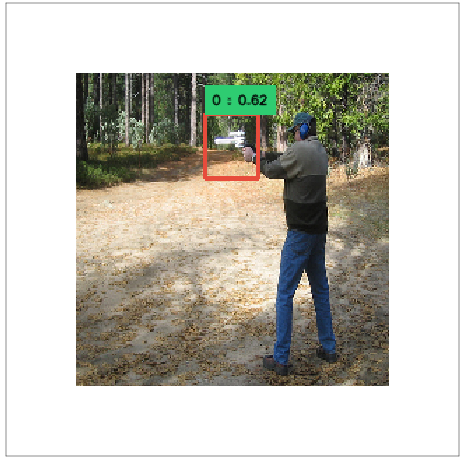

In [156]:
img_idx = 35
result = interpret_output(val_predict_object[img_idx], val_predict_class[img_idx], val_predict_normalized_box[img_idx])
draw_result(val_X_batch[img_idx], result)